Wybierzmy ładne, kolorowe zdjęcie. Postarajmy się by miał kilka dominijących barw oraz jakieś anomalie (np. mały balonik na tle parku, albo samotny X-Wing na tle galaktyki). Potraktujmy każdy jego piksel jako obserwację w przestrzeni 3-D (po jednym wymiarze na każdy z kolorów). Zdecydujmy czy usuwamy ze zbioru duplikaty (piksele o takich samych wartościach RGB) - nasz wybór wpłynie na finalny wynik. Wykonajmy na takim zbiorze klasteryzację k-means, z następującymi założeniami:
    jako środków klastrów używamy istniejące elementy zbioru, a nie ich średnie (czyli jest to w praktyce k-medoids) - nie chcemy znaleźć kolorów, które nie wystąpiły na zdjęciu;
    dobieramy wartość stałej k używając dowolnej zaproponowanej przez siebie metody.
Prezentujemy uzyskaną paletę, oraz wizualizujemy samą klasteryzację (np. rzutujemy punkty ze zbioru na 2D używając PCA, każdemu z nich środek malujemy na pierwotny kolor, a obwódkę na kolor klastra do którego był przyporządkowany).

Następnie na tej samej wizualizacji 2D pokazujemy centra znalezionych klastrów oraz wartość miary Silhouette dla każdego z punktów (jest zawsze z zakresu -1 do 1, można to zwizualizować skalą szarości). Jaki kolor miały oryginalnie punkty o najwyższym Silhouette, a jakie te o najniższym? Czy miara ta nadaje się do wykrywania punktów - anomalii?

In [1]:
from sklearn_extra.cluster import KMedoids
import numpy as np
import imageio
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

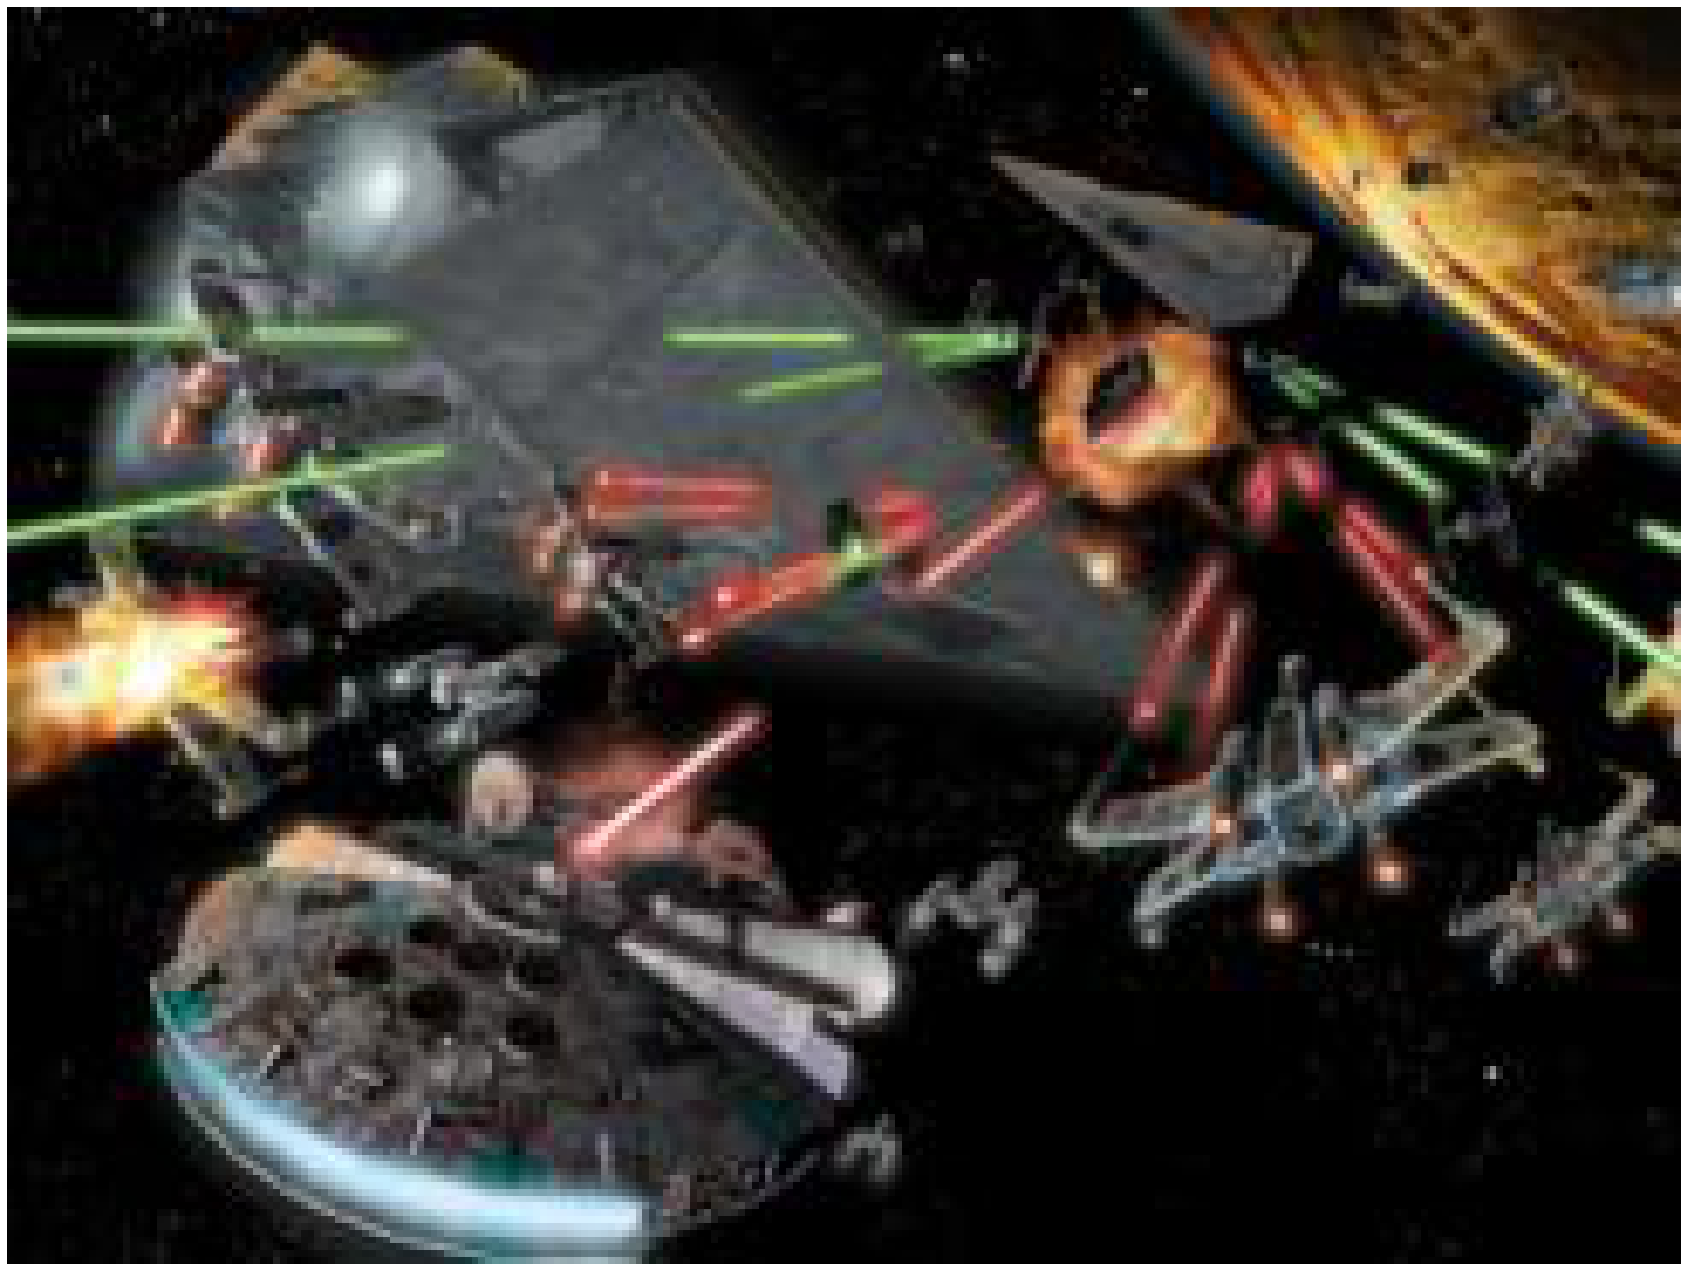

In [2]:
img = imageio.imread('xwing-wal.jpg')
img = np.array(img, dtype=np.float64) / 255
w, h, d = original_shape = tuple(img.shape)
assert d == 3
image_array = np.reshape(img, (w * h, d))
fig, ax = plt.subplots(1,figsize=(30,30))
ax.axis('off')
ax.imshow(img)

In [15]:
kmedoids = KMedoids(metric="euclidean", n_clusters=8)

TypeError: __init__() got an unexpected keyword argument 'n_jobs'

In [4]:
kmedoids.fit(image_array)

/home/pituuuss/anaconda3/lib/python3.7/site-packages/sklearn_extra/cluster/_k_medoids.py:234: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  "its corresponding cluster ({k}).".format(k=k)


KMedoids(init='heuristic', max_iter=300, metric='euclidean', n_clusters=8,
         random_state=None)

In [5]:
labels = kmedoids.predict(image_array)

In [6]:
def recreate_image(codebook, labels, w, h):
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [7]:
colors_count=kmedoids.cluster_centers_.shape[0]

In [8]:
pca = PCA(n_components=2)

In [9]:
concatenated_2D = pca.fit_transform(np.concatenate((image_array,kmedoids.cluster_centers_)))

In [10]:
img_points_2D = concatenated_2D[:-colors_count]
labels_2D = concatenated_2D[-colors_count:]

For n_clusters = 8 The average silhouette_score is : 0.46863583307818474


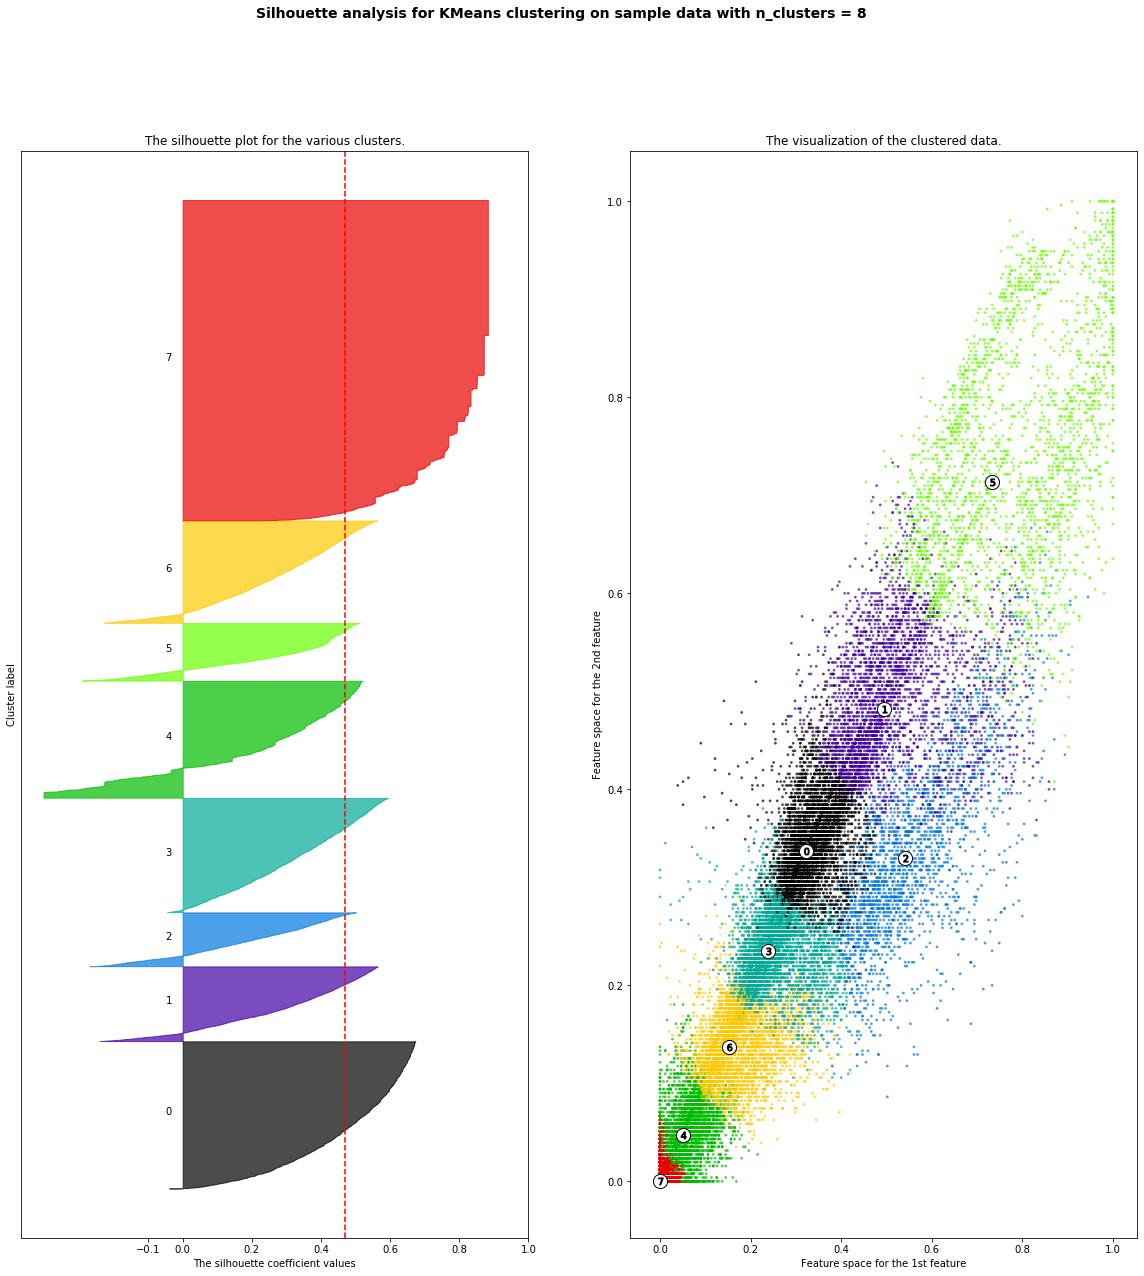

In [11]:
X = image_array
cluster_labels = labels
n_clusters=8
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20))
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = kmedoids.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')

plt.show()

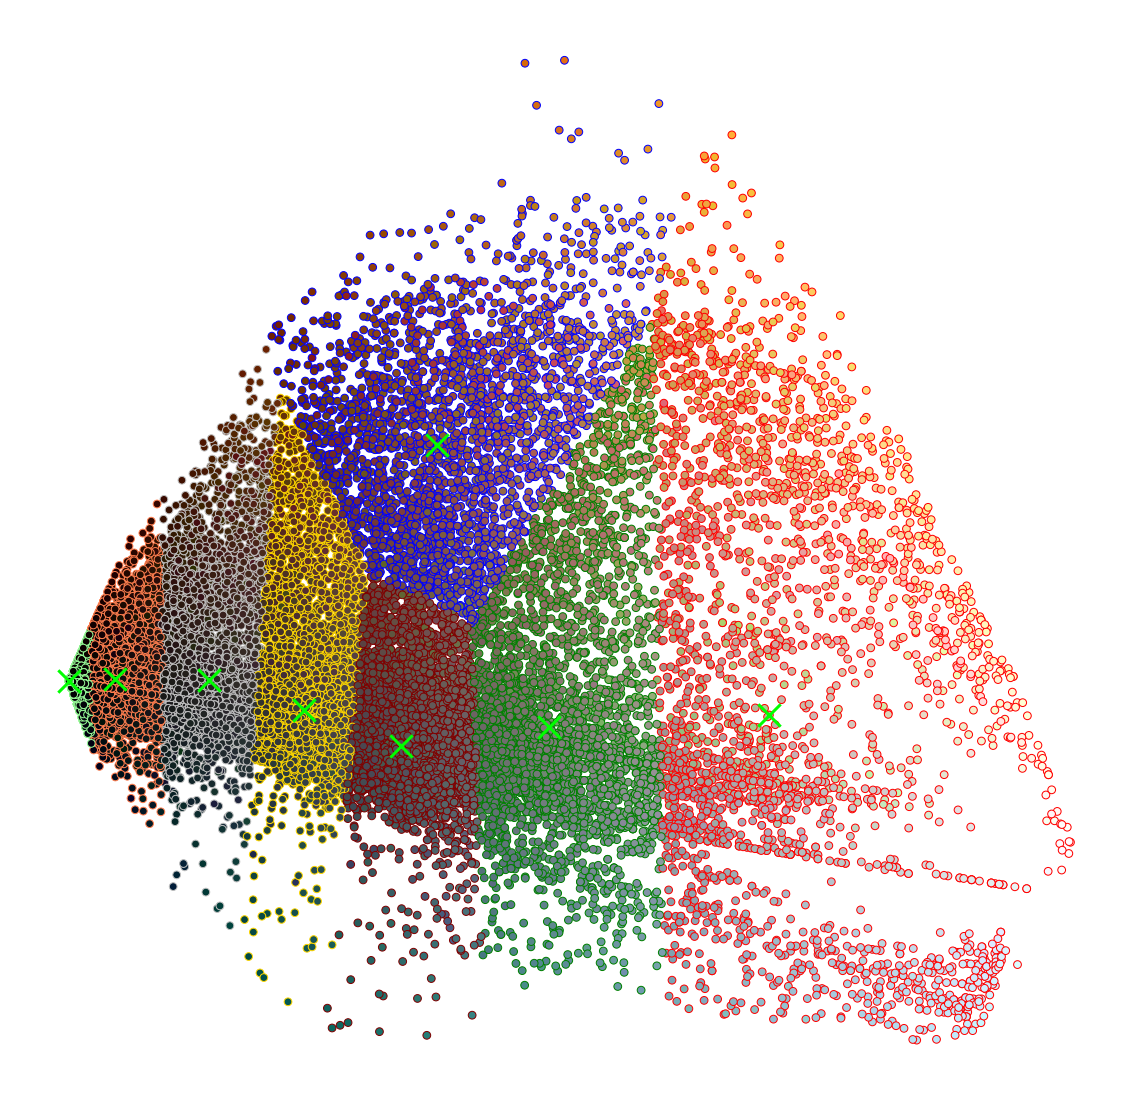

In [14]:
colors=np.array(['maroon','g','b','gold','coral','r','silver','palegreen'])
fig, ax = plt.subplots(1,figsize=(20,20))
ax.axis('off')
ax.scatter(img_points_2D[:,0],img_points_2D[:,1],color=image_array,edgecolors=colors[labels],s=60)
ax.scatter(labels_2D[:,0],labels_2D[:,1],marker='x',c='lime',s=500,linewidth=3)

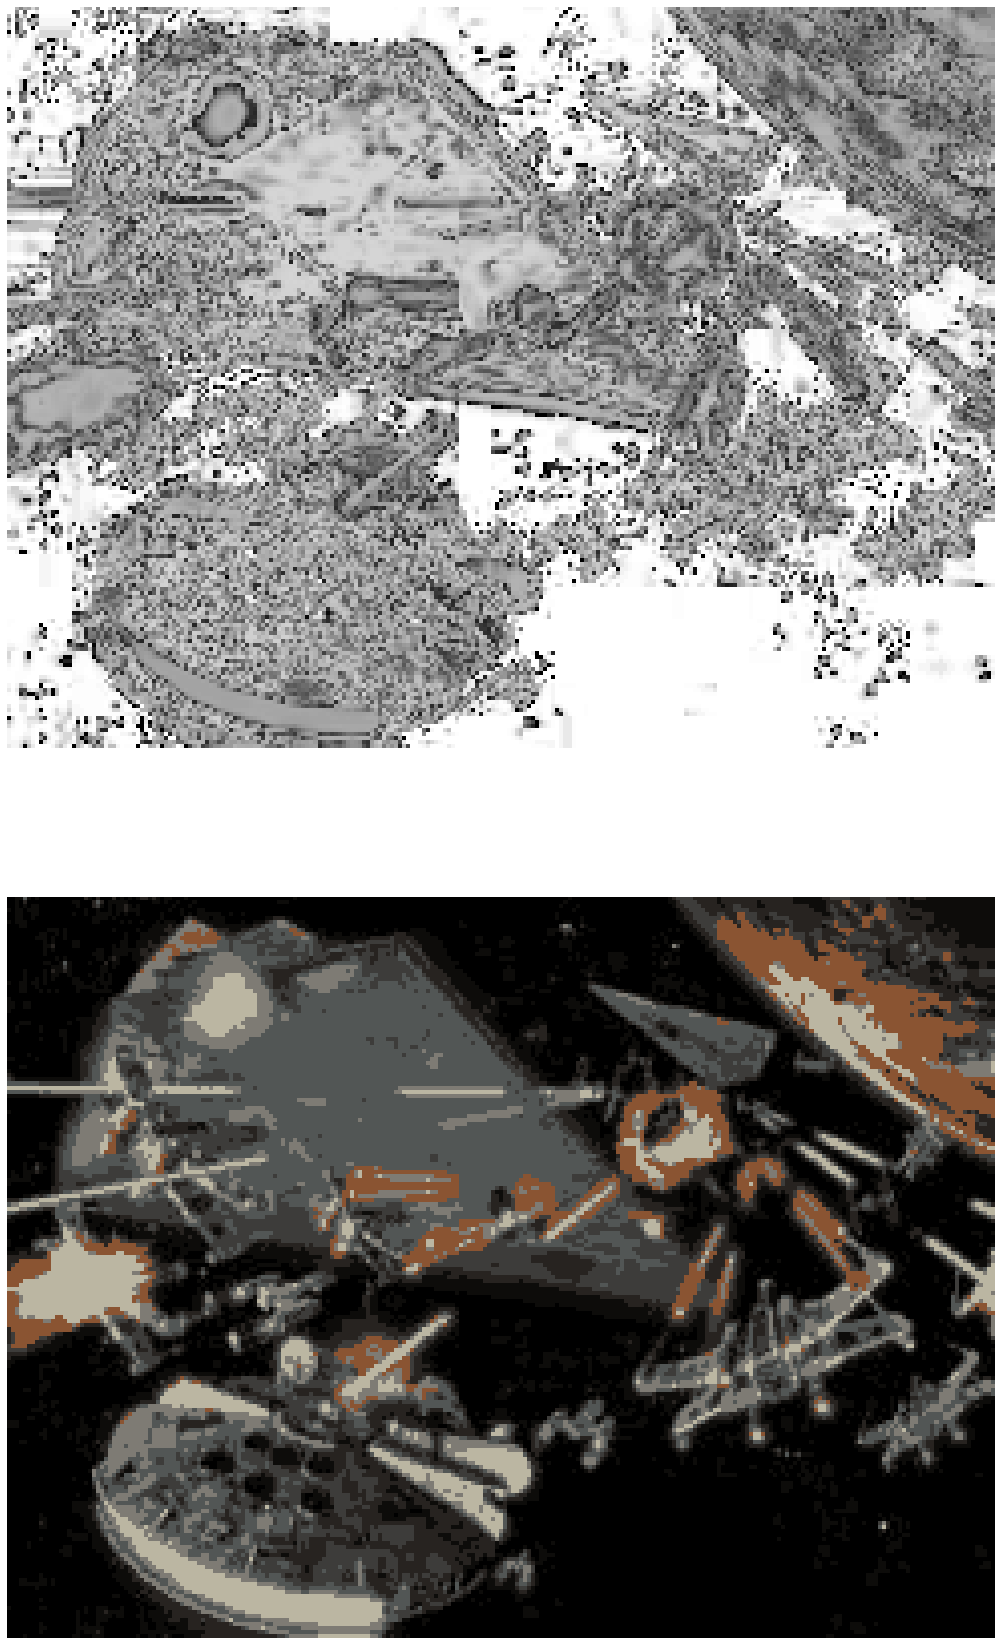

In [13]:
fig, ax = plt.subplots(2,1,figsize=(30,30))
ax[0].axis('off')
ax[0].imshow(sample_silhouette_values.reshape(np.array(img.shape)[:2]),cmap='gray')
ax[1].axis('off')
ax[1].imshow(recreate_image(kmedoids.cluster_centers_, labels, w, h))